In [1]:
import optuna
import optuna.visualization as vis
import time

import scipy.stats as st

from pathlib import Path
import yaml
import pandas as pd

from sklearn.datasets import  fetch_california_housing
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error, make_scorer
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, f1_score
from sklearn.utils import resample

from sklearn.model_selection import cross_val_score

config_path = Path("../config.yaml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

csv_relative_path = config["data"]["clean_data_csv"]["clean_data_v3_irma"]
csv_path = config_path.parent / csv_relative_path

df = pd.read_csv(csv_path)
print(df.shape)
df.head()



config_path = Path("../config.yaml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

csv_relative_path = config["data"]["clean_data_csv"]["clean_data_v3_irma"]
csv_path = config_path.parent / csv_relative_path

df = pd.read_csv(csv_path)
print(df.shape)
df.head()



(7566, 46)
(7566, 46)


,selling_price,km_driven,owner,mileage,engine,max_power,torque,seats,fuel_Diesel,fuel_LPG,...,brand_Nissan,brand_Opel,brand_Peugeot,brand_Renault,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo,car_age
0,0.488000,0.341286,0.0,0.655999,0.535379,0.467401,0.418743,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
1,0.435603,0.316742,1.0,0.582041,0.640637,0.627256,0.498515,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11
2,0.206186,0.336228,2.0,0.472299,0.640276,0.493676,0.040177,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19
3,0.302060,0.323773,0.0,0.642808,0.601599,0.562794,0.081435,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
4,0.152797,0.316742,0.0,0.422550,0.559201,0.553238,0.034175,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18


In [2]:
# Define target and features
X = df.drop(columns=["selling_price"])
y = df["selling_price"]


In [3]:
# Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


(6052, 45) (1514, 45)


In [4]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(X_train)

MinMaxScaler()

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns, index=X_test.index)

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(name, model,
                   X_train_scaled, X_test_scaled,
                   X_train, X_test,
                   y_train, y_test, use_scaled=True):
    """
    Train and evaluate a regression model and store results in the global results_df.
    Automatically removes any previous entry of the same model name to avoid duplicates.
    """

    # Select scaled or unscaled data depending on the model
    if use_scaled:
        Xtr, Xte = X_train_scaled, X_test_scaled
    else:
        Xtr, Xte = X_train, X_test

    # Train the model
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)

    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Update global results without duplicates
    global results_df
    results_df = results_df[results_df["Model"] != name]  # remove old row if it exists

    new_row = pd.DataFrame([{
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }])

    results_df = pd.concat([results_df, new_row], ignore_index=True)

    # Display summary in console
    print(f"{name} -> R²: {r2:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f}")


In [8]:
results_df = pd.DataFrame(columns=["Model", "MAE", "MSE", "RMSE", "R²"])

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Create model KNN before scaling
knn_raw = KNeighborsRegressor()

# Train and predict 
knn_raw.fit(X_train, y_train)
y_pred_knn_raw = knn_raw.predict(X_test)

# Compute metrics
mae_raw = mean_absolute_error(y_test, y_pred_knn_raw)
mse_raw = mean_squared_error(y_test, y_pred_knn_raw)
rmse_raw = np.sqrt(mse_raw)
r2_raw = r2_score(y_test, y_pred_knn_raw)

print("KNN (sin escalar)")
print(f"MAE: {mae_raw:.2f}")
print(f"MSE: {mse_raw:.2f}")
print(f"RMSE: {rmse_raw:.2f}")
print(f"R²: {r2_raw:.4f}")


KNN (sin escalar)
MAE: 0.05
MSE: 0.00
RMSE: 0.06
R²: 0.8888


In [10]:
# Create model KNN after scaling
knn_scaled = KNeighborsRegressor()

# train with scaled data
knn_scaled.fit(X_train_scaled, y_train)
y_pred_knn_scaled = knn_scaled.predict(X_test_scaled)

# compute metrics
mae_scaled = mean_absolute_error(y_test, y_pred_knn_scaled)
mse_scaled = mean_squared_error(y_test, y_pred_knn_scaled)
rmse_scaled = np.sqrt(mse_scaled)
r2_scaled = r2_score(y_test, y_pred_knn_scaled)

print("KNN (con datos escalados)")
print(f"MAE: {mae_scaled:.2f}")
print(f"MSE: {mse_scaled:.2f}")
print(f"RMSE: {rmse_scaled:.2f}")
print(f"R²: {r2_scaled:.4f}")


KNN (con datos escalados)
MAE: 0.04
MSE: 0.00
RMSE: 0.06
R²: 0.8894


### KNN Before vs After Scaling

We tested the KNN model both before and after feature scaling.  
Because the dataset had already been normalized during the cleaning phase (values between 0 and 1),  
the results were almost identical (R² ≈ 0.89).  
This confirms that the features were already scaled properly and no additional normalization was required.


In [11]:
knn_scaled_reg = KNeighborsRegressor()


evaluate_model("knn scaled Regression", knn_scaled_reg, 
               X_train_scaled, X_test_scaled, 
               X_train, X_test, 
               y_train, y_test, use_scaled=True)

knn scaled Regression -> R²: 0.8894 | RMSE: 0.0637 | MAE: 0.0450 | MSE: 0.0041


/var/folders/f1/77pps9rs2l9ffb8_p5tj2yrr0000gp/T/ipykernel_98949/1239188903.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


In [12]:
knn_reg = KNeighborsRegressor()


evaluate_model("knn Regression", knn_reg, 
               X_train, X_test, 
               X_train, X_test, 
               y_train, y_test, use_scaled=True)

knn Regression -> R²: 0.8888 | RMSE: 0.0639 | MAE: 0.0455 | MSE: 0.0041


In [13]:
# Linear Regression (after scaling)
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

evaluate_model("Linear Regression", lin_reg, 
               X_train_scaled, X_test_scaled, 
               X_train, X_test, 
               y_train, y_test, use_scaled=True)


Linear Regression -> R²: 0.8912 | RMSE: 0.0632 | MAE: 0.0483 | MSE: 0.0040


In [14]:
#Bagging Regressor (before scaling)

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=42),  # ← cambio aquí
    n_estimators=100,
    bootstrap=True,   # True = Bagging (con reemplazo)
    random_state=42
)

evaluate_model("Bagging (DecisionTree)", bagging,
               X_train_scaled, X_test_scaled, 
               X_train, X_test,
               y_train, y_test, use_scaled=False)


Bagging (DecisionTree) -> R²: 0.9294 | RMSE: 0.0509 | MAE: 0.0355 | MSE: 0.0026


In [15]:
#Pasting Regressor (before scaling)
pasting = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=42),  # ← cambio aquí también
    n_estimators=100,
    bootstrap=False,   # False = Pasting (sin reemplazo)
    random_state=42
)

evaluate_model("Pasting (DecisionTree)", pasting,
               X_train_scaled, X_test_scaled, 
               X_train, X_test,
               y_train, y_test, use_scaled=False)



Pasting (DecisionTree) -> R²: 0.8967 | RMSE: 0.0616 | MAE: 0.0411 | MSE: 0.0038


In [16]:
# Random Forest (before scaling)
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42
)

evaluate_model("Random Forest", rf,
               X_train_scaled, X_test_scaled, 
               X_train, X_test,
               y_train, y_test, use_scaled=False)


Random Forest -> R²: 0.9297 | RMSE: 0.0508 | MAE: 0.0354 | MSE: 0.0026


In [17]:
# Gradient Boosting (before scaling)
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

evaluate_model("Gradient Boosting", gbr,
               X_train_scaled, X_test_scaled, 
               X_train, X_test,
               y_train, y_test, use_scaled=False)


Gradient Boosting -> R²: 0.9266 | RMSE: 0.0519 | MAE: 0.0387 | MSE: 0.0027


In [18]:
#Adaptive Boosting (AdaBoost) before scaling
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(
    n_estimators=200,
    learning_rate=0.8,
    random_state=42
)

evaluate_model("AdaBoost", ada,
               X_train_scaled, X_test_scaled, 
               X_train, X_test,
               y_train, y_test, use_scaled=False)


AdaBoost -> R²: 0.8296 | RMSE: 0.0791 | MAE: 0.0647 | MSE: 0.0063


In [19]:
results_df.sort_values(by="R²", ascending=False).reset_index(drop=True)


,Model,MAE,MSE,RMSE,R²
0,Random Forest,0.035444,0.002580,0.050796,0.929722
1,Bagging (DecisionTree),0.035536,0.002593,0.050926,0.929361
2,Gradient Boosting,0.038733,0.002696,0.051923,0.926566
3,Pasting (DecisionTree),0.041116,0.003794,0.061597,0.896656
4,Linear Regression,0.048306,0.003994,0.063195,0.891224
5,knn scaled Regression,0.044976,0.004061,0.063728,0.889382
6,knn Regression,0.045527,0.004082,0.063891,0.888816
7,AdaBoost,0.064656,0.006255,0.079091,0.829618


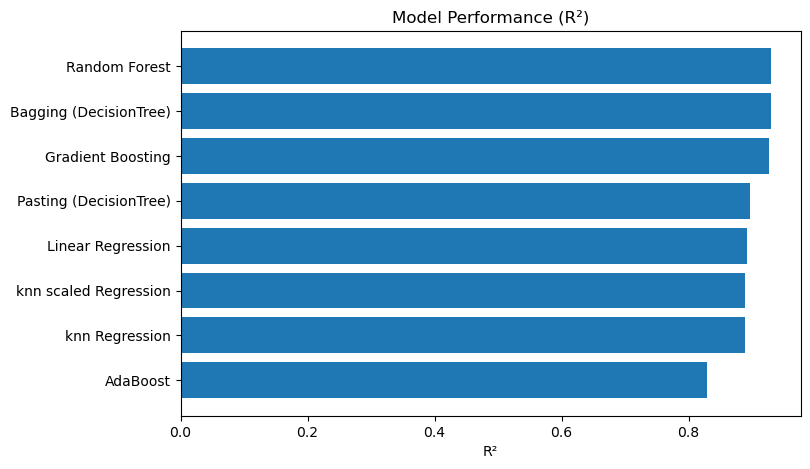

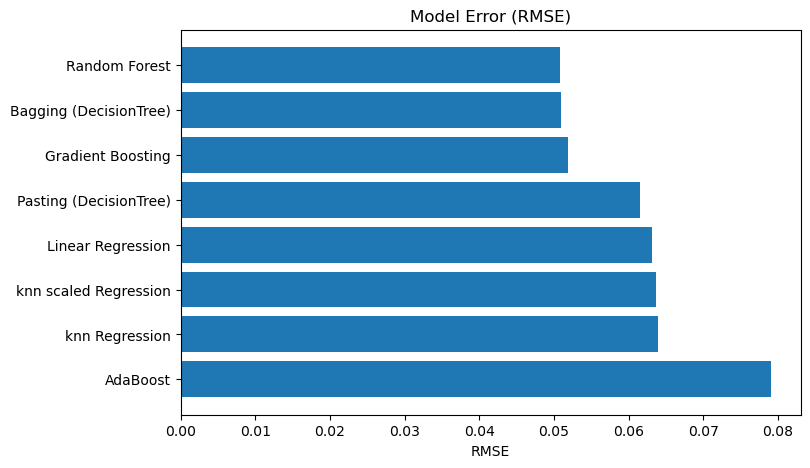

In [20]:
import matplotlib.pyplot as plt

tmp = results_df.sort_values(by="R²", ascending=True)

plt.figure(figsize=(8,5))
plt.barh(tmp["Model"], tmp["R²"])
plt.title("Model Performance (R²)")
plt.xlabel("R²")
plt.show()

plt.figure(figsize=(8,5))
plt.barh(tmp["Model"], tmp["RMSE"])
plt.title("Model Error (RMSE)")
plt.xlabel("RMSE")
plt.show()


### Model Evaluation Summary

We evaluated several regression models to predict car selling prices.  
The following metrics were used: **MAE**, **MSE**, **RMSE**, and **R²**.

**Key findings:**
- **Random Forest** achieved the best overall performance (R² = 0.93), indicating strong predictive power and stability.  
- **Bagging (Decision Tree)** performed nearly as well, confirming the benefit of ensemble averaging.  
- **Gradient Boosting** also showed robust performance, slightly below Random Forest.  
- **Linear Regression** and **KNN** achieved decent but weaker results, as expected for non-ensemble methods.  
- **AdaBoost** underperformed, possibly due to sensitivity to outliers and non-linear relationships.

In conclusion, **Random Forest** was selected as the best model for further optimization (hyperparameter tuning) because it provides the best balance between bias and variance.


### Grid Search
we define a grid of hyperparameter values we want to try. Grid Search tries all possible combinations.

So far, our best model was ????? a R-Squared of ????.

In [22]:
# First we need to setup a dicstionary with all the values that we want to try for each hyperparameter

parameter_grid = {"max_depth": [10, 50],
                  "min_samples_split": [4, 16],
                  "max_leaf_nodes": [250, 100],
                  "max_features": ["sqrt", "log2"]} # In example we're going to test 2 * 2 * 2 * 2 = 16 combinations of hyperparameters

# We create an instance or our machine learning model
ddt = RandomForestRegressor(random_state=123)

# We need to set this two variables to be able to compute a confidence interval
confidence_level = 0.95
folds = 10

# Now we need to create an intance of the GridSearchCV class
gs = GridSearchCV(dt, param_grid=parameter_grid, cv=folds, verbose=10) # Here the "cv" allows you to define the number of folds to use.

start_time = time.time()
gs.fit(X_train_scaled, y_train)
end_time = time.time()

print("\n")
print(f"Time taken to find the best combination of hyperparameters among the given ones: {end_time - start_time: .4f} seconds")
print("\n")


print(f"The best combination of hyperparameters has been: {gs.best_params_}")
print(f"The R2 is: {gs.best_score_: .4f}")

results_gs_df = pd.DataFrame(gs.cv_results_).sort_values(by="mean_test_score", ascending=False)


gs_mean_score = results_gs_df.iloc[0,-3]
gs_sem = results_gs_df.iloc[0,-2] / np.sqrt(10)

gs_tc = st.t.ppf(1-((1-confidence_level)/2), df=folds-1)
gs_lower_bound = gs_mean_score - ( gs_tc * gs_sem )
gs_upper_bound = gs_mean_score + ( gs_tc * gs_sem )

print(f"The R2 confidence interval for the best combination of hyperparameters is: \
    ({gs_lower_bound: .4f}, {gs_mean_score: .4f}, {gs_upper_bound: .4f}) ")

# Let's store the best model
best_model = gs.best_estimator_

# Now is time evaluate the model in the test set
y_pred_test_df = best_model.predict(X_test_scaled)
y_pred_test_df = best_model.predict(X_test_scaled)

y_pred_test_df = best_model.predict(X_test_scaled)

print("\n")
print(f"Test MAE: {mean_absolute_error(y_pred_test_df, y_test): .4f}")
print(f"Test MSE: {mean_squared_error(y_pred_test_df, y_test): .4f}")
print(f"Test RMSE: {root_mean_squared_error(y_pred_test_df, y_test): .4f}")
print(f"Test R2 score:  {best_model.score(X_test_scaled, y_test): .4f}")
print("\n")



Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10; 1/16] START max_depth=10, max_features=sqrt, max_leaf_nodes=250, min_samples_split=4
[CV 1/10; 1/16] END max_depth=10, max_features=sqrt, max_leaf_nodes=250, min_samples_split=4;, score=0.893 total time=   0.7s
[CV 2/10; 1/16] START max_depth=10, max_features=sqrt, max_leaf_nodes=250, min_samples_split=4
[CV 2/10; 1/16] END max_depth=10, max_features=sqrt, max_leaf_nodes=250, min_samples_split=4;, score=0.888 total time=   0.6s
[CV 3/10; 1/16] START max_depth=10, max_features=sqrt, max_leaf_nodes=250, min_samples_split=4
[CV 3/10; 1/16] END max_depth=10, max_features=sqrt, max_leaf_nodes=250, min_samples_split=4;, score=0.883 total time=   0.5s
[CV 4/10; 1/16] START max_depth=10, max_features=sqrt, max_leaf_nodes=250, min_samples_split=4
[CV 4/10; 1/16] END max_depth=10, max_features=sqrt, max_leaf_nodes=250, min_samples_split=4;, score=0.900 total time=   0.5s
[CV 5/10; 1/16] START max_depth=10, max_features=sqrt

### Random Search
We define probability distributions for each hyperparameter, from which random values are sampled. It’s up to the researcher to set the maximum number of combinations.

In [23]:
parameter_grid = {"max_leaf_nodes": [int(x) for x in np.linspace(start = 5, stop = 30, num = 3)],
        "max_depth":[int(x) for x in np.linspace(1, 11, num = 3)]}

dt = RandomForestRegressor(random_state=123)

# n_iter specifies how many randomly selected combinations of hyperparameters will be tested.
rs = RandomizedSearchCV(dt, param_distributions = parameter_grid, n_iter = 16, cv = folds, verbose=10, random_state=123)

start_time = time.time()
rs.fit(X_train_scaled, y_train)
end_time = time.time()

print("\n")
print(f"Time taken to find the best combination of hyperparameters among the given ones: {end_time - start_time: .4f} seconds")
print("\n")


print(f"The best combination of hyperparameters has been: {rs.best_params_}")
print(f"The R2 is: {rs.best_score_: .4f}")

results_rs_df = pd.DataFrame(rs.cv_results_).sort_values(by="mean_test_score", ascending=False)

#print(results_df.head())
rs_mean_score = results_rs_df.iloc[0,-3]
rs_sem = results_rs_df.iloc[0,-2] / np.sqrt(10)

rs_tc = st.t.ppf(1-((1-confidence_level)/2), df=folds-1)
rs_lower_bound = rs_mean_score - ( rs_tc * gs_sem )
rs_upper_bound = rs_mean_score + ( rs_tc * gs_sem )

print(f"The R2 confidence interval for the best combination of hyperparameters is: \
    ({rs_lower_bound: .4f}, {rs_mean_score: .4f}, {rs_upper_bound: .4f}) ")

#display(results_df)

# Let's store the best model
best_model = rs.best_estimator_

# Now is time evaluate the model in the test set
y_pred_test_df = best_model.predict(X_test_scaled)
y_pred_test_df = best_model.predict(X_test_scaled)

y_pred_test_df = best_model.predict(X_test_scaled)

print("\n")
print(f"Test MAE: {mean_absolute_error(y_pred_test_df, y_test): .4f}")
print(f"Test MSE: {mean_squared_error(y_pred_test_df, y_test): .4f}")
print(f"Test RMSE: {root_mean_squared_error(y_pred_test_df, y_test): .4f}")
print(f"Test R2 score:  {best_model.score(X_test_scaled, y_test): .4f}")
print("\n")

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=16. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10; 1/9] START max_depth=1, max_leaf_nodes=5..............................
[CV 1/10; 1/9] END max_depth=1, max_leaf_nodes=5;, score=0.362 total time=   0.7s
[CV 2/10; 1/9] START max_depth=1, max_leaf_nodes=5..............................
[CV 2/10; 1/9] END max_depth=1, max_leaf_nodes=5;, score=0.408 total time=   0.5s
[CV 3/10; 1/9] START max_depth=1, max_leaf_nodes=5..............................
[CV 3/10; 1/9] END max_depth=1, max_leaf_nodes=5;, score=0.366 total time=   0.4s
[CV 4/10; 1/9] START max_depth=1, max_leaf_nodes=5..............................
[CV 4/10; 1/9] END max_depth=1, max_leaf_nodes=5;, score=0.356 total time=   0.5s
[CV 5/10; 1/9] START max_depth=1, max_leaf_nodes=5..............................
[CV 5/10; 1/9] END max_depth=1, max_leaf_nodes=5;, score=0.363 total time=   0.5s
[CV 6/10; 1/9] START max_depth=1, max_leaf_nodes=5..............................
[CV 6/10; 1/9] END max_depth=1, max_leaf_no

### Bayesian search

In [24]:
def objective(trial, confidence_level, folds):

    # First, we define the grid with values to consider when train several possible combinations.
    # Now we specify a range/list of values to try for each hyper-parameter, and we let optuna to decide which
    # combination to try.
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 4, 16)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 250, 1000)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    dt = RandomForestRegressor(random_state=123,
                               max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               max_leaf_nodes=max_leaf_nodes,
                               max_features=max_features)

    # Here the parameter "cv" specifies the number of folds K
    scores = cross_val_score(dt, X_train_scaled, y_train, cv=folds) # The scores provided will be the R2 on each hold out fold
    mean_score = np.mean(scores)
    sem = np.std(scores, ddof=1) / np.sqrt(folds)

    tc = st.t.ppf(1-((1-confidence_level)/2), df=folds-1)
    lower_bound = mean_score - ( tc * sem )
    upper_bound = mean_score + ( tc * sem )

    # Here, we're storing confidence interval for each trial. It's not possible for the objective function to return
    # multiple values as Optuna uses the only returned value to find the best combination of hyperparameters.
    trial.set_user_attr("CV_score_summary", [round(lower_bound,4), round(np.mean(scores),4), round(upper_bound,4)])

    return np.mean(scores)


In [25]:
confidence_level = 0.95
folds = 10

start_time = time.time()
study = optuna.create_study(direction="maximize") # We want to have the maximum values for the R2 scores
study.optimize(lambda trial: objective(trial, confidence_level, folds), n_trials=45)
#study.optimize(objective(**settings), n_trials=45) # n_trials is the number of combinations of hyperparameters to test.
end_time = time.time()

print("\n")
print(f"Time taken to find the best combination of hyperparameters among the given ones: {end_time - start_time: .4f} seconds")
print("\n")
print("The best combination of hyperparameters found was: ", study.best_params)
print(f"The best R2 found was: {study.best_value: .4f}")


[I 2025-10-17 09:29:12,000] A new study created in memory with name: no-name-8fdcea52-c377-4279-84e9-81656a333f79
[I 2025-10-17 09:29:20,947] Trial 0 finished with value: 0.9189892557803354 and parameters: {'max_depth': 30, 'min_samples_split': 6, 'max_leaf_nodes': 737, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9189892557803354.
[I 2025-10-17 09:29:26,031] Trial 1 finished with value: 0.9093698031637076 and parameters: {'max_depth': 19, 'min_samples_split': 6, 'max_leaf_nodes': 457, 'max_features': 'log2'}. Best is trial 0 with value: 0.9189892557803354.
[I 2025-10-17 09:29:31,396] Trial 2 finished with value: 0.9105531675128846 and parameters: {'max_depth': 14, 'min_samples_split': 16, 'max_leaf_nodes': 844, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9189892557803354.
[I 2025-10-17 09:29:39,017] Trial 3 finished with value: 0.9157055213657296 and parameters: {'max_depth': 18, 'min_samples_split': 8, 'max_leaf_nodes': 519, 'max_features': 'sqrt'}. Best is trial



Time taken to find the best combination of hyperparameters among the given ones:  403.7101 seconds


The best combination of hyperparameters found was:  {'max_depth': 28, 'min_samples_split': 8, 'max_leaf_nodes': 881, 'max_features': 'sqrt'}
The best R2 found was:  0.9208


###Comparison

***GRID***

Time taken to find the best combination of hyperparameters among the given ones:  98.3092 seconds


The best combination of hyperparameters has been: {'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': 250, 'min_samples_split': 16}
The R2 is:  0.9055
The R2 confidence interval for the best combination of hyperparameters is:     ( 0.9005,  0.9055,  0.9104) 


Test MAE:  0.0412
Test MSE:  0.0031
Test RMSE:  0.0555
Test R2 score:   0.9162


***Random***

Time taken to find the best combination of hyperparameters among the given ones:  79.9290 seconds


The best combination of hyperparameters has been: {'max_leaf_nodes': 30, 'max_depth': 11}
The R2 is:  0.8669
The R2 confidence interval for the best combination of hyperparameters is:     ( 0.8619,  0.8669,  0.8718) 


Test MAE:  0.0498
Test MSE:  0.0042
Test RMSE:  0.0651
Test R2 score:   0.8845

***Bayesian search***

Time taken to find the best combination of hyperparameters among the given ones:  403.7101 seconds


The best combination of hyperparameters found was:  {'max_depth': 28, 'min_samples_split': 8, 'max_leaf_nodes': 881, 'max_features': 'sqrt'}
The best R2 found was:  0.9208

In [26]:
#study.trials[-1].user_attrs
results = sorted([(index,
  trial.user_attrs['CV_score_summary'][0],
  trial.user_attrs['CV_score_summary'][1],
  trial.user_attrs['CV_score_summary'][2]) for index, trial in enumerate(study.trials)], key=lambda x: x[2], reverse=True)

print(f"The R2 confidence interval for the best combination of hyperparameters is: {results[0][1:]}")
#len(study.trials)

The R2 confidence interval for the best combination of hyperparameters is: (np.float64(0.9157), np.float64(0.9208), np.float64(0.926))


The central value 0.8701 is the expected mean of R² — that is, the model explains about 87.01% of the variance in the validation data.

The minimum (0.861) and maximum (0.8792) values make up the confidence interval, indicating that with high confidence the true R² lies between 86.1% and 87.92%

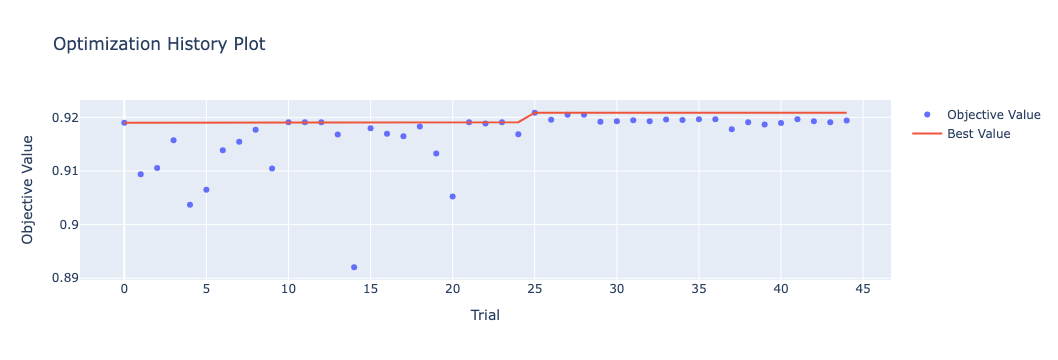

In [34]:
# Plot optimization history
vis.plot_optimization_history(study)
#The more trials, closer is the objective value to the best value



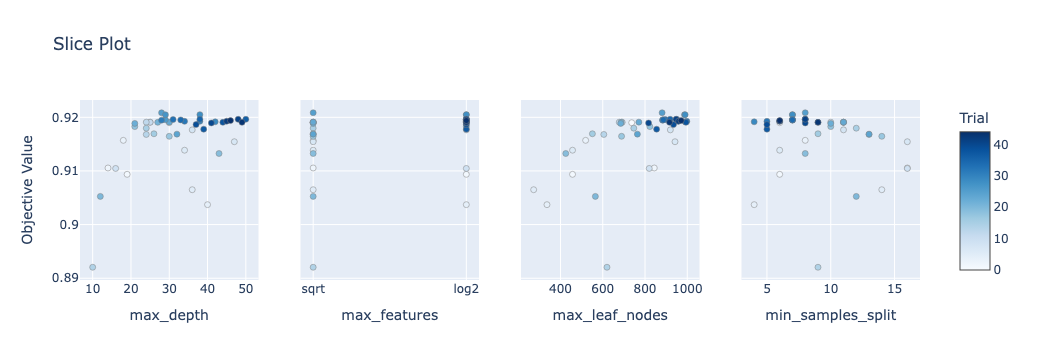

In [28]:
slice_plot = vis.plot_slice(study)
slice_plot.show()

In [36]:
# Create the model Random forest with the best hyper parametrs and test it.
best_model = RandomForestRegressor(random_state=123, **study.best_params)
best_model.fit(X_train_scaled, y_train)

# Make prediction
y_pred_test_df = best_model.predict(X_test_scaled)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Gide us the result
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_df))

print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test_df): .3f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_test_df): .3f}")
print(f"Test RMSE: {rmse: .3f}")
print(f"Test R2 score:  {best_model.score(X_test_scaled, y_test): .3f}")


Test MAE:  0.036
Test MSE:  0.003
Test RMSE:  0.051
Test R2 score:   0.930
